In [1]:
import pandas as pd
import numpy as np

# Load the data and pivot so that each PID is a column
data = pd.read_csv('classified_driving_data.csv')
data_wide = data.pivot_table(index='interval', columns='PID', values='VALUE', aggfunc='mean')

Preprocessing data

In [2]:
from tensorflow import keras
from keras import Sequential

# Merge the classification column back to the df
classification = data[['interval', 'classification']].drop_duplicates()
data_wide = pd.merge(data_wide, classification, on='interval')

# Interval is not needed for training, and can be dropped here
X = data_wide.drop(columns=['classification', 'interval'])
y = keras.utils.to_categorical(data_wide['classification'].map({'Normal': 0, 'Slow': 1, 'Aggressive': 2}))

# Handle any missing values by filling with the mean of that column
X.fillna(X.mean(), inplace=True)

Preparing data for model training

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data and scale features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Logistic Regression Model

In [4]:
from sklearn.linear_model import LogisticRegression

# Training the model
logreg_direct = LogisticRegression()
y_train_classes = np.argmax(y_train, axis=1)
logreg_direct.fit(X_train, y_train_classes)

# Prediction
y_pred_logreg_direct = logreg_direct.predict(X_test)
y_test_classes = np.argmax(y_test, axis=1)

Neural Network Model

In [5]:
model = Sequential()
model.add(keras.layers.Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax')) 

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training the model
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

# Predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3801 - loss: 1.0871 - val_accuracy: 0.6129 - val_loss: 0.9858
Epoch 2/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.6150 - loss: 0.9631 - val_accuracy: 0.7161 - val_loss: 0.8623
Epoch 3/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 874us/step - accuracy: 0.7662 - loss: 0.8139 - val_accuracy: 0.8258 - val_loss: 0.6786
Epoch 4/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 856us/step - accuracy: 0.8439 - loss: 0.6339 - val_accuracy: 0.9097 - val_loss: 0.4990
Epoch 5/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 833us/step - accuracy: 0.8879 - loss: 0.4663 - val_accuracy: 0.9161 - val_loss: 0.3653
Epoch 6/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 777us/step - accuracy: 0.8839 - loss: 0.3730 - val_accuracy: 0.9226 - val_loss: 0.2847
Epoch 7/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 813us/step - accuracy: 0.8881 - loss: 0.3016 - val_accuracy: 0.9355 - val_loss: 0.2307
Epoch 8/50
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 785us/step - accuracy: 0.9047 - loss: 0.2528 - val_accuracy: 0.9548 - val_lo

Model Results

Logistic Regression Accuracy: 97.87%
Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98       294
           1       1.00      0.96      0.98       119
           2       0.99      0.95      0.97       103

    accuracy                           0.98       516
   macro avg       0.99      0.97      0.98       516
weighted avg       0.98      0.98      0.98       516



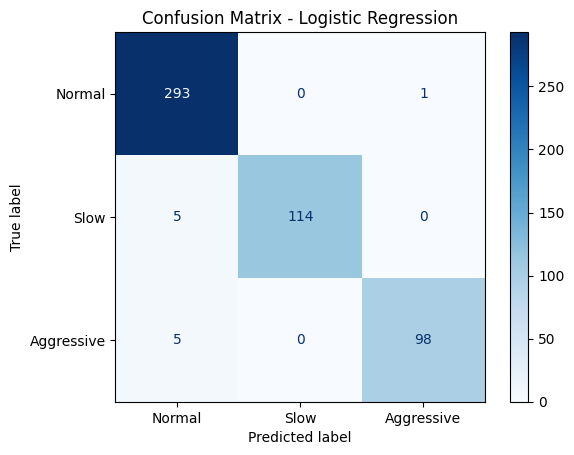

In [6]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_labels = ['Normal', 'Slow', 'Aggressive']

print(f"Logistic Regression Accuracy: {accuracy_score(y_test_classes, y_pred_logreg_direct) * 100:.2f}%")
print("Logistic Regression Classification Report:\n", classification_report(y_test_classes, y_pred_logreg_direct))

# Logistic Regression Confusion Matrix
cm_logreg = confusion_matrix(y_test_classes, y_pred_logreg_direct)
disp_logreg = ConfusionMatrixDisplay(confusion_matrix=cm_logreg, display_labels=class_labels)
disp_logreg.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

Neural Network Accuracy: 97.09%
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       294
           1       1.00      0.92      0.96       119
           2       0.99      0.95      0.97       103

    accuracy                           0.97       516
   macro avg       0.98      0.96      0.97       516
weighted avg       0.97      0.97      0.97       516



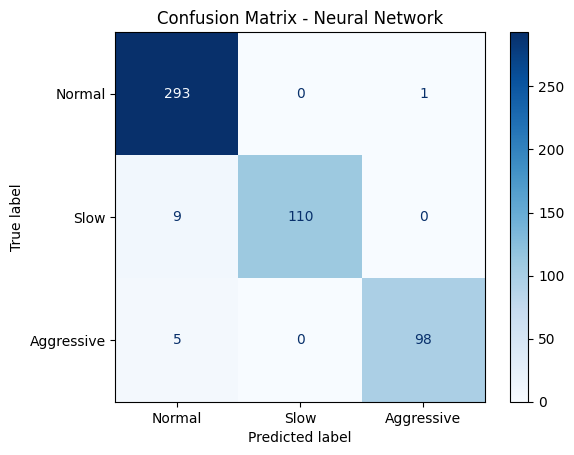

In [7]:
print(f"Neural Network Accuracy: {accuracy_score(y_test_classes, y_pred_classes) * 100:.2f}%")
print("Classification Report:\n", classification_report(y_test_classes, y_pred_classes))

# Neural Network Confusion Matrix
cm_nn = confusion_matrix(y_test_classes, y_pred_classes)
disp_nn = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=class_labels)
disp_nn.plot(cmap='Blues')
plt.title('Confusion Matrix - Neural Network')
plt.show()

In [8]:
# Print what the majority of the training data was classified as
majority_class_index = np.argmax(np.sum(y_train, axis=0))
class_mapping = {0: 'normal', 1: 'slow', 2: 'aggressive'}
print("Based on the training data, the sample is generally classified as", class_mapping[majority_class_index], "driving.")

Based on the training data, the sample is generally classified as normal driving.


Visualization

In [9]:
# For Logistic Regression
incorrect_logreg = y_test_classes != y_pred_logreg_direct

# For Neural Network
incorrect_nn = y_test_classes != y_pred_classes

def plot_incorrect_classifications(X_test, y_test_classes, incorrect_indices, title, class_labels):
    # Color map for each class
    colors = ['green', 'blue', 'purple']
    
    # Makes the plot wider so data is easier to see
    plt.figure(figsize=(14, 6))

    # Create a scatter plot for each class
    for i, label in enumerate(class_labels):
        plt.scatter(X_test[y_test_classes == i, 0], X_test[y_test_classes == i, 1], 
                    color=colors[i], label=f'{label}', alpha=0.6)
    
    # Plot the incorrect classifications
    plt.scatter(X_test[incorrect_indices, 0], X_test[incorrect_indices, 1], 
                color='red', marker='x', label='Incorrect Predictions')
    
    plt.title(title)
    plt.legend()
    plt.show()

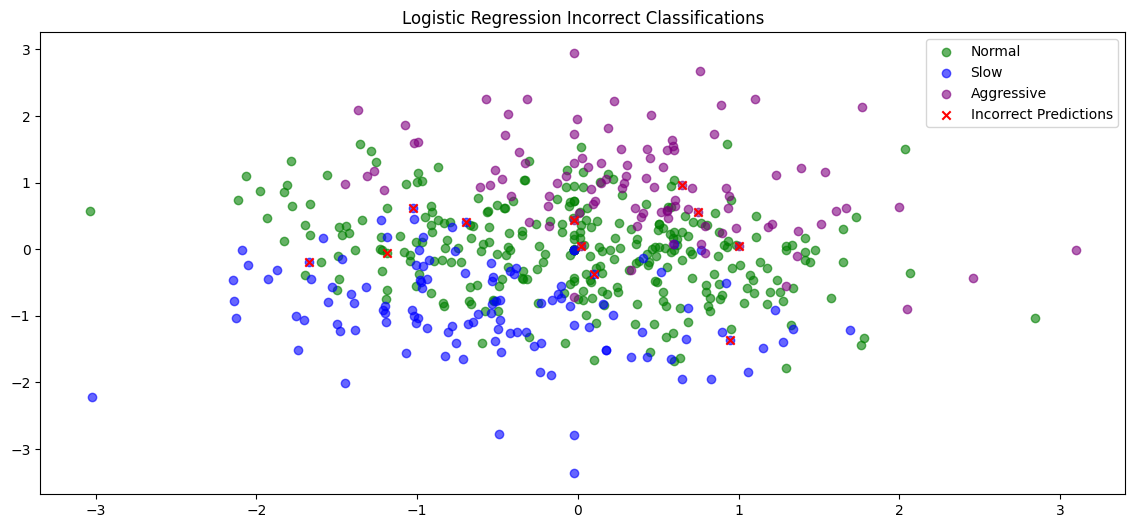

In [10]:
# Logistic Regression Incorrect Classifications
plot_incorrect_classifications(X_test, y_test_classes, incorrect_logreg, 
                               'Logistic Regression Incorrect Classifications', class_labels)

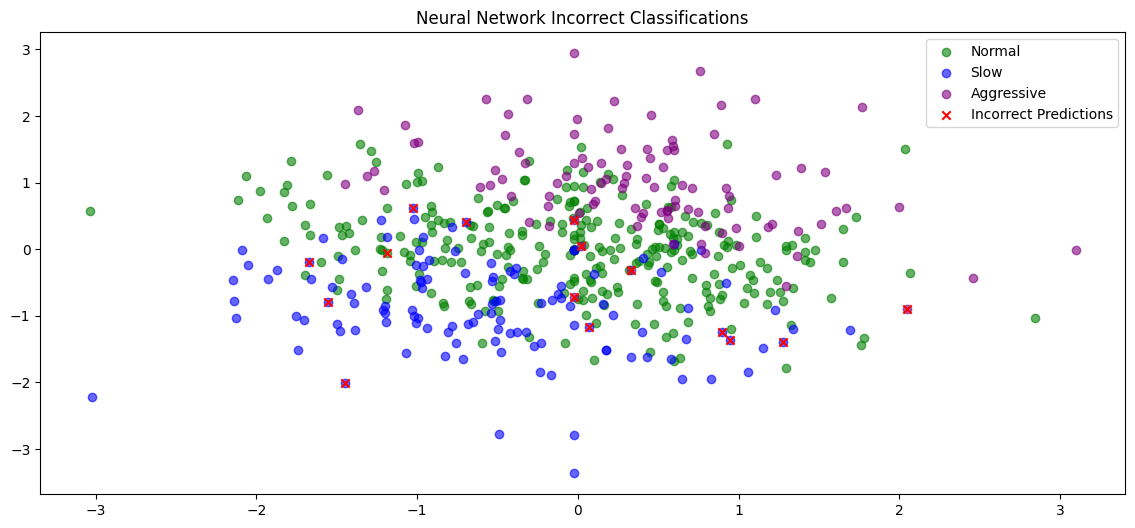

In [11]:
# Neural Network Incorrect Classifications
plot_incorrect_classifications(X_test, y_test_classes, incorrect_nn, 
                               'Neural Network Incorrect Classifications', class_labels)